# Recommendations with IBM

In this notebook, we will be using real data to analyze the interactions that users have with articles on the IBM Watson Studio platform to make recommendations to them about new articles they may like.

By following the table of contents, we will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns

from sklearn.metrics import mean_absolute_error 

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?

In the dataset provided, there is no specific column for user ids. However, the column email can be used instead to identify unique users.

In [3]:
# Get the no of article by user
user_article = df.groupby('email')['article_id'].count()

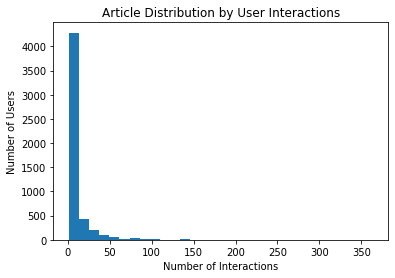

In [4]:
#user_article.plot.hist()
plt.hist(user_article, bins=30)
plt.title('Article Distribution by User Interactions')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.show()

Looks like we have a skewed distribution where most of the interactions are around 0-10.
Let's have a closer look at the distribution

In [5]:
user_article.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [6]:
# Median and maximum number of user_article interactios below

median_val = 3 # 
max_views_by_user = 364 # 
print('50% of individuals interact with {} number of articles or fewer.'.format(median_val))
print('The maximum number of user-article interactions by any 1 user is {}.'.format(max_views_by_user))

50% of individuals interact with 3 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset=['article_id'], keep=False)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [8]:
print('We have {} duplicate articles in df_content'.format(df_content.duplicated(subset=['article_id']).sum()))

We have 5 duplicate articles in df_content


In [9]:
df_content.shape

(1056, 5)

In [10]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'], keep='first')

In [11]:
df_content.shape

(1051, 5)

In [12]:
# The number of unique articles that have an interaction with a user.  
df.article_id.nunique()

714

In [13]:
# The number of unique articles in the dataset (whether they have any interactions or not)
df_content.article_id.nunique()

1051

In [14]:
# The number of unique users in the dataset. (excluding null values)
df.email.nunique()

5148

In [15]:
# The number of user-article interactions in the dataset.
df.shape[0]

45993

`4.` Next we will find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
# The most viewed article in the dataset 
df.groupby('article_id')['email'].count().sort_values(ascending=False).iloc[:1]

article_id
1429.0    937
Name: email, dtype: int64

In [17]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [18]:
print('`50% of individuals have {} or fewer interactions.`'.format(median_val))
print('`The maximum number of user-article interactions by any 1 user is {}.`'.format(max_views_by_user))

`50% of individuals have 3 or fewer interactions.`
`The maximum number of user-article interactions by any 1 user is 364.`


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In here, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` We will create functions below to return the **n** top articles ordered with most interactions as the top. 

In [19]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 

    '''

    top_articles = df.groupby('title')['user_id'].count(
    ).sort_values(ascending=False).index[:n].tolist()
    
    # Return the top article titles
    return top_articles


def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 

    '''

    top_articles = df.groupby('article_id')['user_id'].count().sort_values(
        ascending=False).index[:n].astype('str').tolist()

    return top_articles  # Return the top article ids

In [20]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` We will create functions below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [21]:
# create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns

    OUTPUT:
    user_item - user item matrix 

    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''

    # create user item matrix
    user_item = df.groupby(['user_id', 'article_id'])[
        'title'].count().unstack()

    # Values greater than 1 to be replaced with 1
    user_item = user_item.applymap(lambda x: 1 if x > 1 else x)
    
    # Replace NaNs with zeroes
    user_item.fillna(0, inplace=True)

    return user_item  # return the user_item matrix


user_item = create_user_item_matrix(df)

`2.`The function below will should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result will not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 


In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_idx = np.where(user_item.index == user_id)[0][0]
    user_similarity_scores = np.array(user_item.iloc[user_idx]).dot(
        np.transpose(np.array(user_item)))
    user_similarity_scores = list(enumerate(user_similarity_scores))
    
    # sort by similarity
    similarity_scores_sorted = sorted(user_similarity_scores, key = lambda x: x[1], reverse=True)
    
    # create list of just the ids
    most_similar_users = [user_item.index[x[0]] for x in similarity_scores_sorted]
    
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar       

In [23]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that we have a function that provides the most similar users to each user, we will use these users to find articles you can recommend. The functions below will return the articles we would recommend to each user. 

In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df.article_id.isin(article_ids)].title.unique().tolist()
    
    return article_names  # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)

    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(
        'str').tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names  # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily

    '''
    recs = np.array([])

    # Find the articles user interacted with
    user_articles, user_article_names = get_user_articles(user_id)
    
    similar_users = find_similar_users(user_id)
    
    # Find recommended articles from the list of articles similar users interacted with
    for user in similar_users:
        # Fetch similar articles for neighbor
        similar_articles, similar_article_names = get_user_articles(user)
        # Generate recommendation by excluding the articles user already interacted with
        new_recs = np.array(np.setdiff1d(similar_articles, user_articles))
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
                            
        if len(recs) > m:
            break
            
    # Return only the specified no of articles
    recs = recs[:m]
    
    return recs  # return your recommendations for this user_id

In [25]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we will choose the users that have the most total article interactions before choosing those with fewer article interactions.

* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we will choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking will be  what would be obtained from the **top_articles** function we wrote earlier.

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook
    user_item - (pandas dataframe) matrix of users by articles:
            1's when a user has interacted with an article, 0 otherwise


    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u

    Other Details - sort the neighbors_df by the similarity and then by number of interactions where
                    highest of each is higher in the dataframe

    '''
    # Create empty list to store neigbors data
    neighbor_data = []
    # Find neighbors
    neighbors = find_similar_users(user_id)
    # Create similarity matrix between users
    similarity_matrix = np.array(user_item).dot(np.transpose(np.array(user_item)))
    
    # Find similarity and number of interactions for each neighbors
    for neighbor in neighbors :
        user_idx = user_item.index.get_loc(user_id)
        neighbor_idx = user_item.index.get_loc(neighbor)

        similarity = similarity_matrix[user_idx, neighbor_idx]
        num_interactions = df.groupby(
            ['user_id'])['article_id'].count().loc[neighbor]
        
        neighbor_data.append([neighbor, similarity, num_interactions])

    # Create neighbors_df from neighbor_data
    neighbors_df = pd.DataFrame(data=neighbor_data, columns=[
        'neighbor_id', 'similarity', 'num_interactions'])
    # Sort the neighbors_df by the similarity and then by number of interactions
    neighbors_df = neighbors_df.sort_values(
        by=['similarity', 'num_interactions'], ascending=False)
    
    return neighbors_df  # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    * Choose the users that have the most total article interactions
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions
    before choosing those with fewer total interactions.

    '''
    user_articles, user_article_names = get_user_articles(user_id)
    neighbors_df = get_top_sorted_users(user_id)
    recs = np.array([])
    
    # Find recommended articles from the list of articles similar users interacted with
    for neighbor in neighbors_df.neighbor_id:
        # Fetch articles that has neighbor interactions
        neighbor_articles, neighbor_article_names = get_user_articles(
            neighbor)
        # Generate recommendation by excluding the articles user already interacted with
        new_recs = np.array(np.setdiff1d(neighbor_articles, user_articles))
        # Prioritise articles that has more user interactions
        get_top_article_ids(len(new_recs), df[df.article_id.isin(new_recs)])
        # Remove duplicate recommendations derived from neighbors
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        if len(recs) > m:
            break
            
    # Return only the specified no of articles
    recs = recs[:m]
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [27]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0' '1085.0' '109.0' '1150.0' '1151.0' '1152.0' '1153.0' '1154.0'
 '1157.0' '1160.0']

The top 10 recommendations for user 20 are the following article names:
['airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark', 'tensorflow quick tips', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice reviews', 'using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: chicago listings']


In [28]:
user1_most_sim = get_top_sorted_users(1).neighbor_id.iloc[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbor_id.iloc[9]# Find the 10th most similar user to user 131

In [29]:
print('The user that is most similar to user 1.'.format(user1_most_sim))
print('The user that is the 10th most similar to user 131'.format(user131_10th_sim))

The user that is most similar to user 1.
The user that is the 10th most similar to user 131


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  

For new users we can't calculate similarity scores since we don't have data for their interactions with article.
In this case, it makes sense to reecommend the most popular articles to the user.
We can make use of get_top_articles to make this recommendation.

`7.` Using our existing functions, we will provide the top 10 recommended articles for the a new user below.  

In [30]:
print('Top 10 article ids for new users'.format(get_top_article_ids(10)))

Top 10 article ids for new users


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, we will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix as there are no missing values.. 

Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  

Next, we will split our dataset into a training and test set of data, as shown in the cell below.  

We will try to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [31]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

# Create user item matrices for train and test data
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [32]:
common_idx = np.intersect1d(test_idx,user_item_train.index)
print('There are {} users present in both test and train data'.format(len(common_idx)))

There are 20 users present in both test and train data


In [33]:
only_test_idx = np.setdiff1d(test_idx,user_item_train.index)
print('There are {} users present in test data but absent in train data'.format(len(only_test_idx)))

There are 662 users present in test data but absent in train data


In [34]:
common_arts = np.intersect1d(test_arts,user_item_train.columns)
print('There are {} articles present in both test and train data'.format(len(common_arts)))

There are 574 articles present in both test and train data


In [35]:
only_test_arts = np.setdiff1d(test_arts, user_item_train.columns)
print('There are {} articles present in test data but absent in train data'.format(len(only_test_arts)))

There are 0 articles present in test data but absent in train data


Now we can the **user_item_train** dataset from above to find U, S, and V transpose using SVD and then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. 

In the cells below we will explore how well SVD works towards making predictions for recommendations on the test data.  

In [36]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

Using SVD, we can make predictions for only those users and articles in test data that are also present in train data.

In [37]:
# Extract the common user rows from test
user_item_test_common = user_item_test.loc[common_idx]

In [38]:
# Get the index of the common users and articles in train and test
train_common_idx_bool = user_item_train.index.isin(test_idx)
train_common_arts_bool = user_item_train.columns.isin(test_arts)
# Create u_test and vt_test based on the common index
u_test = u_train[train_common_idx_bool, :]
vt_test = vt_train[:, train_common_arts_bool]

print('u_test matrix sizes: ', u_test.shape)
print('vt_test matrix sizes: ', vt_test.shape)

u_test matrix sizes:  (20, 4487)
vt_test matrix sizes:  (714, 574)


In [39]:
num_latent_feats = np.arange(10, 700+10, 20)
sum_errs = []
sum_errs_val = []
accuracy_train = []
accuracy_test = []
new_k =[]
for k in num_latent_feats:
    # restructure with k latent features
    k = 700 - k
    new_k.append(k)
    s_new_train, u_new_train, vt_new_train = np.diag(
        s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_new_test, vt_new_test = u_test[:, :k], vt_test[:k, :]

    # take dot product for train
    user_item_train_pred = np.around(np.dot(np.dot(u_new_train, s_new_train), vt_new_train))
    # take dot product for test
    user_item_test_pred = np.around(np.dot(np.dot(u_new_test, s_new_train), vt_new_test))

    # calculate train and test accuracy
    accuracy_train.append(
        1 - mean_absolute_error(user_item_train, user_item_train_pred))
    accuracy_test.append(
        1 - mean_absolute_error(user_item_test_common, user_item_test_pred))

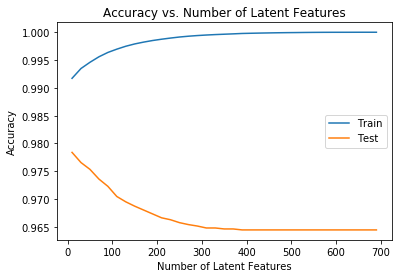

In [40]:
# Plot train and test accuracy based on number of latent features
plt.plot(new_k,accuracy_train, label='Train')
plt.plot(new_k,accuracy_test, label='Test')
plt.legend(loc='right')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
plt.show()

The recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

<a id='conclusions'></a>
### Conclusions
From the plot above, predictions using SVD seem to be better when the latent factors are in the 20 to 100 range. With the increase in latent factors, the model complexity increases, leading to overfitting. Also, we made recommendations for only 20 users, which is quite less considering the system has more than 5000 unique users. Simply, there are not enough interactions between users and articles. Getting more interactions can help us in dealing with this problem of overfitting and make better recommendations using SVD.

Gathering data for this may take some time as user-article interactions will increase gradually over time. Till the articles have substantial number of user interactions, we can recommend the top articles and use methods like content based recommendation. This is much better than the current system which only shows newest articles to users. 
Also, we can do A/B testing to check if our new recommendation system is actually resulting in more user-article interactions.
Using your workbook, we could now save our recommendations for each user, develop a class to make new predictions and update our results, and make a flask app to deploy our results.  